## EXPLORATORY DATA ANALYSIS (EDA) - FootySage

En primer lugar vamos a importar las librerías que nos van a hacer falta.

In [22]:
import pandas as pd

#from statsbombpy import sb
from mplsoccer import Pitch

Ahora cargamos las competiciones, los partidos, los eventos, las alineaciones y las métricas 360, para poder realizar el estudio de los datos.

In [2]:
import os
from glob import glob    # para encontrar todos los nombres de archivo que coincidan con el patrón especificado


ruta_datos = '/Users/jaime/Desktop/TFG (FootySage)/Datos StatsBomb/open-data-master/data/'

# cargar el archivo de competiciones
competitions_df = pd.read_json(os.path.join(ruta_datos, 'competitions.json'))

# función para cargar múltiples archivos JSON desde una carpeta o subcarpetas
def load_json_files(path_pattern, recursive=False):
    if recursive:
        files = glob(path_pattern, recursive=True)
    else:
        files = glob(path_pattern)  
    data_frames = []
    for file in files:
        df = pd.read_json(file)
        data_frames.append(df)
    if data_frames:
        return pd.concat(data_frames, ignore_index=True)
    else:
        return pd.DataFrame()  # devolvemos un dataframe vacío si no se encuentran archivos

# cargar todos los archivos de partidos
matches_df = load_json_files(os.path.join(ruta_datos, 'matches', '**', '*.json'), recursive=True)
#events_df = load_json_files(os.path.join(ruta_datos, 'events', '*.json'))
#lineups_df = load_json_files(os.path.join(ruta_datos, 'lineups', '*.json'))
#metrics_360_df = load_json_files(os.path.join(ruta_datos, 'three-sixty', '*.json'))

Una vez cargados los datos ya estamos en disposición de empezar a trabajar con ellos.

### Información general de las competiciones

En primer lugar, vamos a realizar un estudio de las competiciones de las que tenemos información. Para ello vamos a pintar un gráfico que nos va a ayudar a saber más acerca de estas competiciones.

El gráfico que vamos a ver es la distribución de partidos por competición, es decir, vamos a visualizar una gráfica donde podremos ver cuantos partidos hay registrados de cada competición.

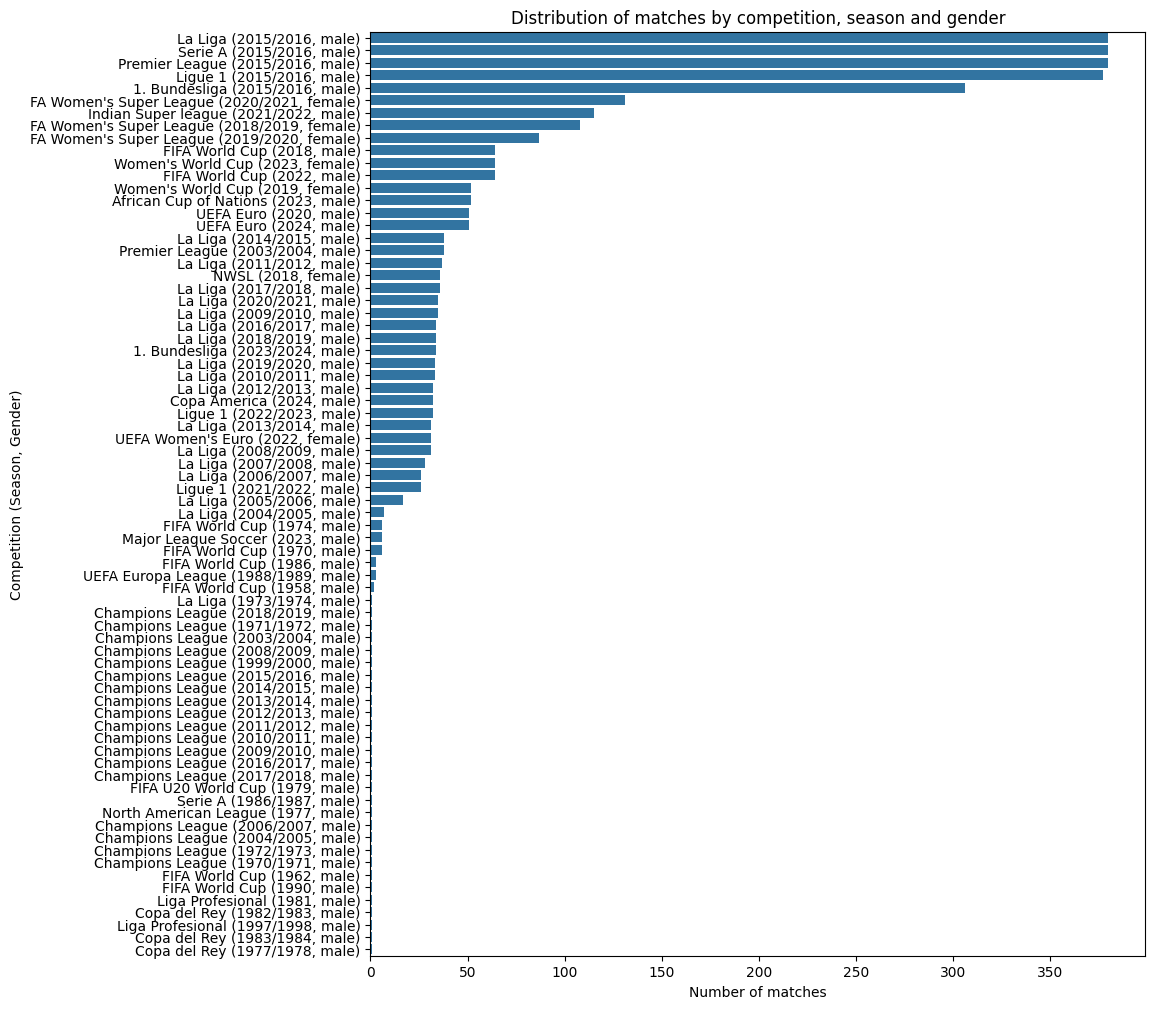

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


# extraer las columnas necesarias desde las estructuras anidadas
matches_df['competition_name'] = matches_df['competition'].apply(lambda x: x['competition_name'] if isinstance(x, dict) else None)
matches_df['season_name'] = matches_df['season'].apply(lambda x: x['season_name'] if isinstance(x, dict) else None)
matches_df['competition_gender'] = matches_df['home_team'].apply(lambda x: x['home_team_gender'] if isinstance(x, dict) else None)

# crear una columna combinada para identificar cada competición de manera única
matches_df['competition_key'] = matches_df['competition_name'] + ' (' + matches_df['season_name'] + ', ' + matches_df['competition_gender'] + ')'

# crear el gráfico usando la columna combinada
plt.figure(figsize=(10, 12))
sns.countplot(y='competition_key', data=matches_df, order=matches_df['competition_key'].value_counts().index)
plt.title('Distribution of matches by competition, season and gender')
plt.xlabel('Number of matches')
plt.ylabel('Competition (Season, Gender)')
plt.show()

Como podemos observar hay varias competiciones que no tienen todos los datos completos de la temporada y esto se debe a que como bien sabemos las ligas regulares masculinas incluyen un total de 380 partidos (siempre y cuando sean 20 equipos, si fuese el caso de la Bundesliga que son 18 equipos son 306 partidos), FA Women's Super League a partir de 2019 son 132 partidos, FA Women's Super League en la temporada 2018/2019 son 104 partidos, FA Women's Super League en la temporada 2019/2020 son 82 partidos debido a la pandemia mundial, la Copa del Mundo masculina a partir de 2018 son un total de 64 partidos al igual que en la Copa del Mundo femenina de 2023, la Copa del Mundo femenina en 2019 fueron 52 partidos, la Copa Africana de Naciones masculina en 2023 son 52 partidos, la Eurocopa masculina a partir de 2020 son un total de 51 partidos, la NWSL fememina en 2018 fueron 108 partidos, la Copa América de 2024 fueron 32 partidos, la Eurocopa femenina de 2022 fueron un total de 31 partidos, la Copa del Mundo masculina en 1970 y 1974 fueron 38 partidos, la Copa del mundo masculina en 1986 fueron 52 partidos, la Europa League masculina en 1988 fueron, la Champions League incluye un total de 216 partidos excepto para la temporada 2019/2020 que fueron 119 partidos debido a la pandemia mundial, la Copa del Rey incluye un total de 126 partidos 

In [4]:
# para comprobar el número de partidos exacto por competición
comp = matches_df[matches_df['competition_key'] == "UEFA Women's Euro (2022, female)"]
print(comp.shape[0])

31


Por tanto, podemos decir que las competiciones que tienen registrados todos los partidos son: LaLiga (2015/2016, male), Serie A (2015/2016, male), Premier League (2015/2016, male), 1. Bundesliga (2015/2016, male), FA Women's Super League (2020/2021, female), Indian Super league (2021/2022, male), FA Women's Super League (2018/2019, female), FA Women's Super League (2019/2020, female), FIFA World Cup (2018, male), Women's World Cup (2023, female), FIFA World Cup (2022, male), Women's World Cup (2019, female), African Cup of Nations (2023, male), UEFA Euro (2020, male), UEFA Euro (2024, male), Copa America (2024, male), UEFA Women's Euro (2022, female)

### Análisis de resultados en partidos y de los equipos (importancia de jugar como local)

En primer lugar, vamos a presentar dos gráficos en los que podemos el procentaje de victoria, derrota y empate de los equipos que juegan como locales y luego el mismo gráfico pero con los equipos que juegan como visitante para de esta manera ver si jugar con la afición a favor puede influir o no.

In [5]:
# función para crear columna para el resultado del equipo local
def home_team_result(row):
    if row['home_score'] > row['away_score']:
        return 'win'
    elif row['home_score'] == row['away_score']:
        return 'draw'
    else:
        return 'loss'

# función para crear columna para el resultado del equipo visitante
def away_team_result(row):
    if row['away_score'] > row['home_score']:
        return 'win'
    elif row['away_score'] == row['home_score']:
        return 'draw'
    else:
        return 'loss'

In [6]:
# aplicar las funciones para calcular los resultados desde ambas perspectivas
matches_df['home_result'] = matches_df.apply(home_team_result, axis=1)
matches_df['away_result'] = matches_df.apply(away_team_result, axis=1)

In [7]:
# contamos los resultados para los equipos locales
home_results_counts = matches_df['home_result'].value_counts(normalize=True)

# contamos los resultados para los equipos visitantes
away_results_counts = matches_df['away_result'].value_counts(normalize=True)

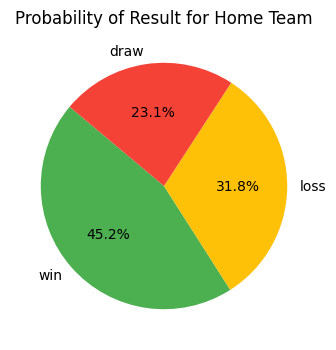

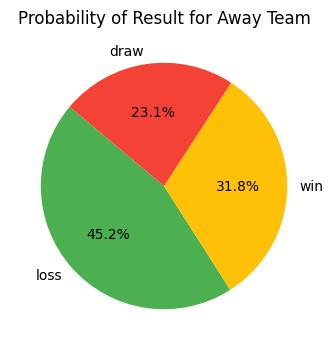

In [8]:
# gráfico de sectores para equipos locales
plt.figure(figsize=(4,4))
plt.pie(home_results_counts, labels=home_results_counts.index, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FFC107', '#F44336'])
plt.title('Probability of Result for Home Team')
plt.show()

# gráfico de sectores para equipos visitantes
plt.figure(figsize=(4,4))
plt.pie(away_results_counts, labels=away_results_counts.index, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FFC107', '#F44336'])
plt.title('Probability of Result for Away Team')
plt.show()

Como podemos observar, en prácticamente un 50% de los casos el equipo que juega como local gana y el equipo que juega como visitante pierde. Luego, jugar con el público a favor es un factor muy importante en el fútbol ya que ejercen mayor presión sobre el rival y los jugadores del equipo local se crecen ante el apoyo de los aficionados.

Aunque si es cierto que es lo general, hay equipos que se manejan de igual manera tanto dentro como fuera de casa, mientras que otros dependen mucho de los resultados de casa. Para ver la diferencia entre estos dos equipos podemos ver los partidos del Sevilla FC y del FC Barcelona en la temporada 2015/2016 de la liga española.

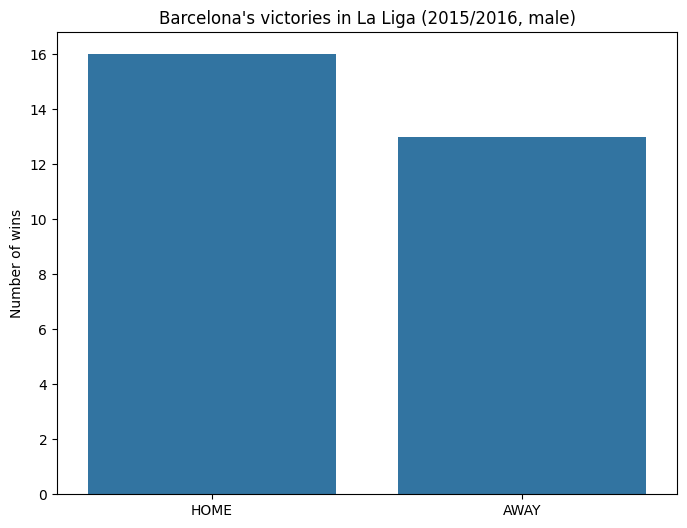

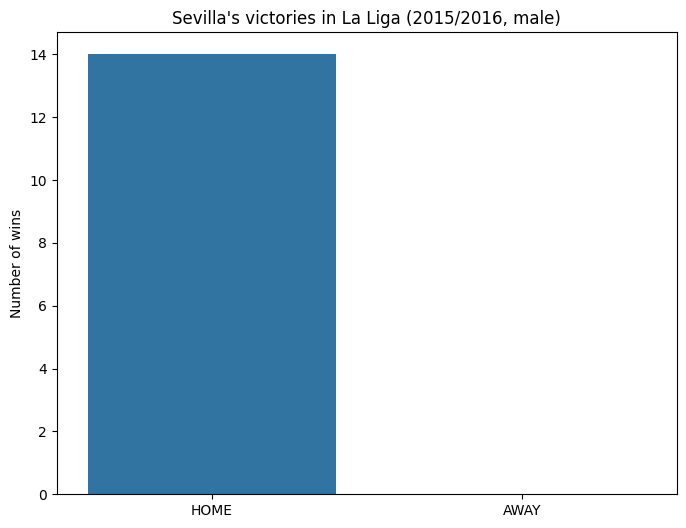

In [9]:
# función que representa la comparativa de número de victorias en casa y fuera de un equipo en una competición determinada
def location_win_graphic(equipo, competicion):
    # filtrar los partidos del equipo en la competición especificada
    equipo_matches = matches_df[
        ((matches_df['home_team'].apply(lambda x: x['home_team_name']) == equipo) | 
         (matches_df['away_team'].apply(lambda x: x['away_team_name']) == equipo)) &
        (matches_df['competition_key'] == competicion)
    ]
    
    # contar las victorias en casa y fuera
    victorias_casa = equipo_matches[(equipo_matches['home_team'].apply(lambda x: x['home_team_name']) == equipo) &
                                    (equipo_matches['home_score'] > equipo_matches['away_score'])].shape[0]
    victorias_fuera = equipo_matches[(equipo_matches['away_team'].apply(lambda x: x['away_team_name']) == equipo) & 
                                     (equipo_matches['away_score'] > equipo_matches['home_score'])].shape[0]
    
    victorias_en = ['HOME', 'AWAY']
    num_victorias = [victorias_casa, victorias_fuera]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=victorias_en, y=num_victorias)
    plt.title(f"{equipo}'s victories in {competicion}")
    plt.ylabel('Number of wins')
    plt.show()

# Ejemplo de uso
location_win_graphic("Barcelona", "La Liga (2015/2016, male)")
location_win_graphic("Sevilla", "La Liga (2015/2016, male)")

Como podemos ver en los anteriores dos gráficos, el FC Barcelona consiguió un número muy parecido de victorias en casa y fuera de su estadio, mientras que el Sevilla FC todo lo contrario, no consiguió ninguna victoria fuera de casa pero si que consiguió muchas victorias en su estado, en esta temporada el FC Barcelona ganó La Liga, mientras que el Sevilla FC a pesar de no ganar ningún partido fuera de casa quedo 7º obteniendo así un billete para las competiciones europeas de la temporada siguiente.

### Distribución de goles por minuto

Vamos a representar un gráfico en el que se vean como se reparten los goles de los partidos a lo largo del partido, para así observar en los periodos de tiempo en los que se meten más goles.

En primer lugar, cargamos los eventos que aún no habíamos podido cargar. Debido a que son una cantidad inmensa de datos vamos a utilizar la librería Dask (https://docs.dask.org/en/stable/). Tarda en cargarse alrededor de una hora.

In [10]:
import json
import dask.dataframe as dd


# función para leer un archivo JSON con diferentes codificaciones
def read_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            return json.load(file)
    except (UnicodeDecodeError, json.JSONDecodeError):
        print(f"Could not read the file {file}.")
    return None


# función para cargar archivos JSON y convertirlos en DataFrames de Dask
def load_json_files_to_dask(path_pattern, recursive=False):
    if recursive:
        files = glob(path_pattern, recursive=True)
    else:
        files = glob(path_pattern)
    
    dask_dfs = []
    #i=0
    for file in files:
        data = read_json_file(file)
        if data:
            # convertir los datos en DataFrame de pandas primero
            df = pd.DataFrame(data)
            # convertir DataFrame de pandas a DataFrame de Dask
            dask_df = dd.from_pandas(df, npartitions=1)
            dask_dfs.append(dask_df)
            #i+=1
            #print(i)
        else:
            print(f"Could not read the file {file} with the known conditions.")
    
    # concatenar todos los DataFrames de Dask en uno solo
    if dask_dfs:
        return dd.concat(dask_dfs, axis=0)
    else:
        return dd.from_pandas(pd.DataFrame(), npartitions=1)

# cargar todos los archivos de eventos
eventos_dd = load_json_files_to_dask(os.path.join(ruta_datos, 'events', '**', '*.json'), recursive=True)
print(f"{eventos_dd.npartitions} events file were loaded.")

Se cargaron 3433 archivos de eventos.


In [11]:
eventos_dd.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'duration',
       'tactics', 'related_events', 'player', 'position', 'location', 'pass',
       'carry', 'ball_receipt', 'under_pressure', 'duel', 'counterpress',
       'interception', 'off_camera', 'ball_recovery', 'shot', 'goalkeeper',
       'clearance', 'block', 'dribble', 'foul_committed', 'foul_won', 'out',
       'miscontrol', 'bad_behaviour', 'substitution', '50_50',
       'injury_stoppage', 'half_start', 'player_off', 'half_end'],
      dtype='object')

Vamos a ver cuales son los atributos que contiene un evento.

Convertiremos los datos a formato Parquet después de cargarlos. El formato Parquet es muy eficiente en cuanto a espacio y permite una lectura/escritura rápida.

In [10]:
# guardamos los DataFrames de eventos formato Parquet
parquet_path_events = os.path.join(ruta_datos, 'processed', 'events.parquet')

# escribimos los datos en formato Parquet
eventos_dd.to_parquet(parquet_path_events)

NameError: name 'eventos_dd' is not defined

Una vez que los datos están en formato Parquet, podemos cargarlos de manera eficiente en cualquier momento sin tener que procesar los JSON nuevamente.

In [10]:
import dask.dataframe as dd
import os

parquet_path_events = os.path.join(ruta_datos, 'processed', 'events.parquet')
events_df = dd.read_parquet(parquet_path_events)

Para ver la distribución de goles por minuto vamos a trabajar con el atributo *type* (tendremos que ver que sea un *shot*), también tendremos que ver el minuto de partido en el que se hizo el tiro con el atributo *minute* y, por último, mirar si el tiro fue gol a través del atributo *shot* tenemos que ver que *outcome* tenga el atributo *name* como "Goal".
Tras tener filtrados los goles y el minuto en el que se hizo representaremos en un diagrama de barras el número de goles que hay por cada minuto de partido.

In [11]:
import ast

# función que usamos para convertir una cadena que parece un diccionario en un diccionario real
def str_to_dict(row):
    try:
        return ast.literal_eval(row)  # convierte la cadena en un diccionario real
    except (ValueError, SyntaxError):
        return None

In [12]:
# aplicamos la conversión de la columna 'type' de cadena a diccionario
events_df['type'] = events_df['type'].map_partitions(lambda df: df.apply(str_to_dict), meta=('type', 'object'))

In [13]:
# función para extraer el atributo 'atr' del diccionario de 'row'
def extract_attribute(row, atr):
    try:
        if isinstance(row, dict):
            return row.get(atr, None)
        return None
    except (TypeError, KeyError):
        return None

In [14]:
# creamos una nueva columna en el dataframe con el nombre del tipo de evento
events_df['type_name'] = events_df['type'].map_partitions(
    lambda df: df.apply(lambda row: extract_attribute(row, 'name')),
    meta=('type_name', 'object')
)

# filtramos por los eventos que sean tiros
tiros_df = events_df[events_df['type_name'] == 'Shot']
num_tiros = tiros_df.shape[0].compute()
print("Number of 'Shot' type events:", num_tiros)

Number of 'Shot' type events: 87111


In [15]:
# convertimos la columna 'shot' de cadena a diccionario, si no es NaN, como hicimos con la columna 'type' anteriormente
tiros_df['shot'] = tiros_df['shot'].map_partitions(lambda df: df.apply(str_to_dict), meta=('shot', 'object'))

In [16]:
# función para ver si un tiro fue gol o no
def is_goal(row):
    if isinstance(row, dict) and 'outcome' in row and isinstance(row['outcome'], dict):
        return row['outcome'].get('name') == 'Goal'
    return False

# creamos una nueva columna que será True si el tiro fue gol
tiros_df['is_goal'] = tiros_df['shot'].map_partitions(lambda df: df.apply(is_goal), meta=('is_goal', 'bool'))

In [17]:
# filtramos solo los tiros que hayan sido gol
goles_df = tiros_df[tiros_df['is_goal']]
num_goles = goles_df.shape[0].compute()
print("Number of 'Shot' type events that were goals:", num_goles)

Number of 'Shot' type events that were goals: 9667


In [18]:
porcentaje_goles = (num_goles/num_tiros)/100
print("Percentage of shots that have ended in a goal:", round(porcentaje_goles,10))

Percentage of shots that have ended in a goal: 0.0011097336


In [19]:
# extraer los minutos en los que se hicieron los goles
minutos_goles_df = goles_df['minute']

# agrupar por minuto y contar el número de goles
conteo_goles_df = goles_df.groupby('minute').size().compute()

In [20]:
import hvplot.pandas

# visualizamos la distribución de goles por minuto en un gráfico de barras directamente desde la Series
conteo_goles_df.hvplot.bar(
    title='Distribution of Goals per Minute in Matches',
    xlabel='Minute',
    ylabel='Number of goals',
    width=800,
    height=400
)

:Bars   [minute]   (0)

Como podemos observar:
* Entre los minutos 0 y 45 (primer tiempo), se observa una distribución bastante uniforme, aunque con algunas variaciones. Los goles parecen distribuidos de manera consistente, excepto en los primeros 5 minutos de partido en los que se suelen dar menos goles.
* Entre los minutos 46 y 90 (segundo tiempo), hay un incremento en los goles, con varios picos más altos alrededor de los minutos 60-80, lo que sugiere que más goles suelen marcarse en la parte final del partido, cuando los equipos están bajo más presión o cansancio.
* Después del minuto 90 (tiempo extra), hay una caída significativa en los goles debido a que en ese instante es cuando suele jugarse la prórroga y es un momento en el que los jugadores están muy desgastados fisicamente. Aunque existe un pequeño grupo pasado el minuto 120, que corresponde a las tandas de penalti (más goles ya que son varios lanzamientos de penalti). Aunque es cierto que no llegan a ser muchos goles debido a que en las ligas regulares no existen esta tanda de penalti ya que solo se da en caso de empate en prórrogas que solo se dan en caso de empate en los partidos de las competiciones más cortas en fase de eliminatorias.

Por lo que podemos decir:
* Hay una tendencia creciente en el número de goles conforme avanza el partido.
* Durante el tiempo extra, los goles son mucho más raros.
* Si hay tanda de penalti, suele haber bastantes goles.

### Mapa de calor de los tiros y de los tiros que han sido gol

Vamos a representar desde los sitios donde es más normal que se haga un tiro en un campo de fútbol a través de un mapa de calor. Para ellos aprovecharemos que en el apartado anterior ya habíamos filtrado los tiros.

In [32]:
# funcion en la que convertimos las coordenadas de cadena de caracteres a lista de floats si es necesario
def convert_location(loc):
    if isinstance(loc, str):
        try:
            return ast.literal_eval(loc) 
        except (ValueError, SyntaxError):
            return None  
    return loc 

# aplicamos solo la conversión cuando la ubicación es una cadena
tiros_df['location'] = tiros_df['location'].apply(convert_location, meta=('location', 'object'))

# filtramos por aquellos tiros de los que tengamos su posición
tiros_posicion_df = tiros_df[tiros_df['location'].notnull()]

# extraemos las coordenadas X y Y de la columna 'location'
tiros_posicion_df['x'] = tiros_posicion_df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None, meta=('x', 'f8'))
tiros_posicion_df['y'] = tiros_posicion_df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None, meta=('y', 'f8'))

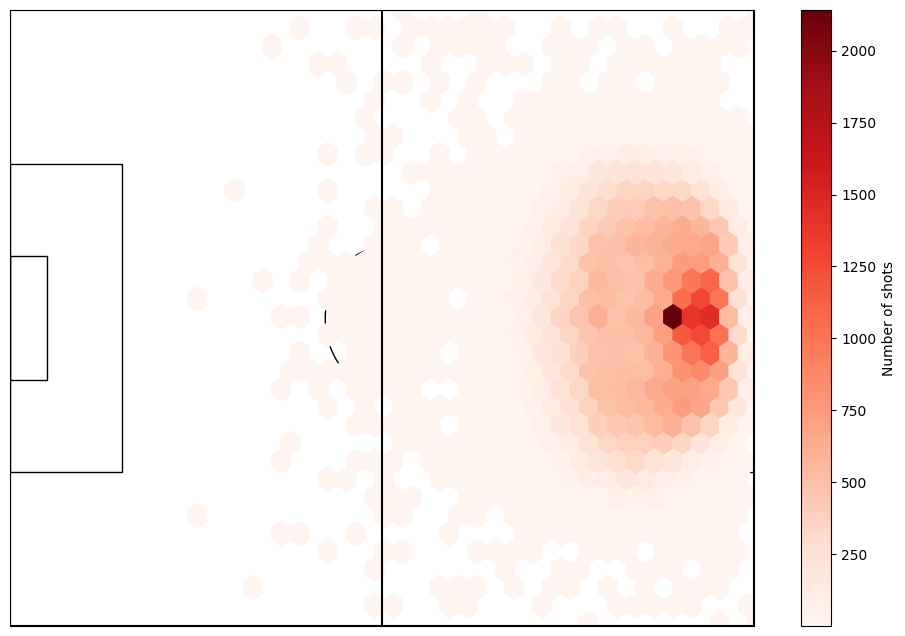

In [33]:
from matplotlib.patches import Rectangle
from bokeh.io import export_png


# función que define el campo de fútbol
def draw_pitch(ax):
    # campo de fútbol dimensión de los datos de statsbomb
    field_dimen = (120, 80)

    # dibuja el campo de fútbol
    ax.set_xlim(0, field_dimen[0])
    ax.set_ylim(0, field_dimen[1])
    ax.set_xticks([])
    ax.set_yticks([])
    
    # líneas del campo
    ax.plot([0, 0], [0, field_dimen[1]], color='black')  # Lado izquierdo
    ax.plot([0, field_dimen[0]], [field_dimen[1], field_dimen[1]], color='black')  # Línea de gol superior
    ax.plot([field_dimen[0], field_dimen[0]], [field_dimen[1], 0], color='black')  # Lado derecho
    ax.plot([field_dimen[0], 0], [0, 0], color='black')  # Línea de gol inferior

    # area grande
    ax.add_patch(Rectangle((0, field_dimen[1] / 2 - 20), 18, 40, edgecolor='black', facecolor='none'))
    ax.add_patch(Rectangle((field_dimen[0] - 18, field_dimen[1] / 2 - 20), 18, 40, edgecolor='black', facecolor='none'))

    # area pequeña
    ax.add_patch(Rectangle((0, field_dimen[1] / 2 - 8), 6, 16, edgecolor='black', facecolor='none'))
    ax.add_patch(Rectangle((field_dimen[0] - 6, field_dimen[1] / 2 - 8), 6, 16, edgecolor='black', facecolor='none'))

    # centro del campo y punto de penalti
    ax.plot([field_dimen[0] / 2, field_dimen[0] / 2], [0, field_dimen[1]], color='black')  # Línea central
    central_circle = plt.Circle((field_dimen[0] / 2, field_dimen[1] / 2), 9.15, edgecolor='black', facecolor='none')
    ax.add_patch(central_circle)


# crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# crear el mapa de calor usando histograma 2D
hb = ax.hexbin(
    tiros_posicion_df['x'], tiros_posicion_df['y'],
    gridsize=30, cmap='Reds', mincnt=1
)

# añadimos la barra de colores
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Number of shots')

# guardamos la imagen
heatmap_img_path = 'heatmap_shots.png'
plt.savefig(heatmap_img_path, bbox_inches='tight')

# mostramos el gráfico
plt.show()

Vamos a hacerlo ahora utilizando un campo más parecido a un campo de fútbol utilizando la librería mplsoccer cargada al inicio.

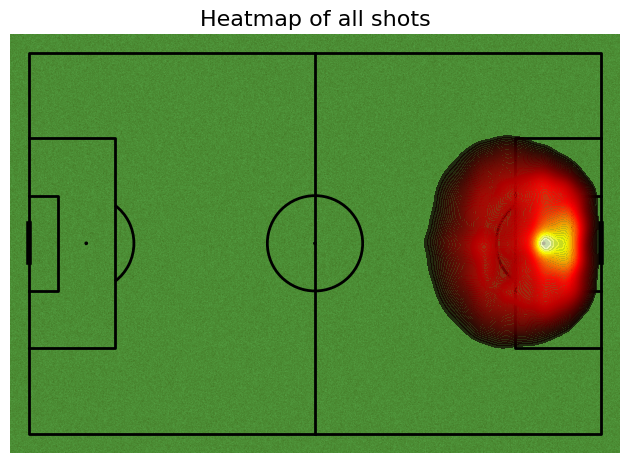

In [35]:
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw()

# dibujar el mapa de calor de los tiros
pitch.kdeplot(tiros_posicion_df['x'], tiros_posicion_df['y'], ax=ax, shade=True, levels=100, cmap='hot', alpha=0.7)

plt.title(f"Heatmap of all shots", fontsize=16)
plt.show()

Como podemos observar en el mapa de calor la mayoría de los tiros se hacen muy cerca de la portería en comparación con los que se hacen lejos de esta. La mayoría de tiros se hacen dentro del área, sobre todo a la altura del punto de penalti.

Ahora vamos a hacer los mismo que hemos hecho anteriormente pero representando los tiros que han sido gol.

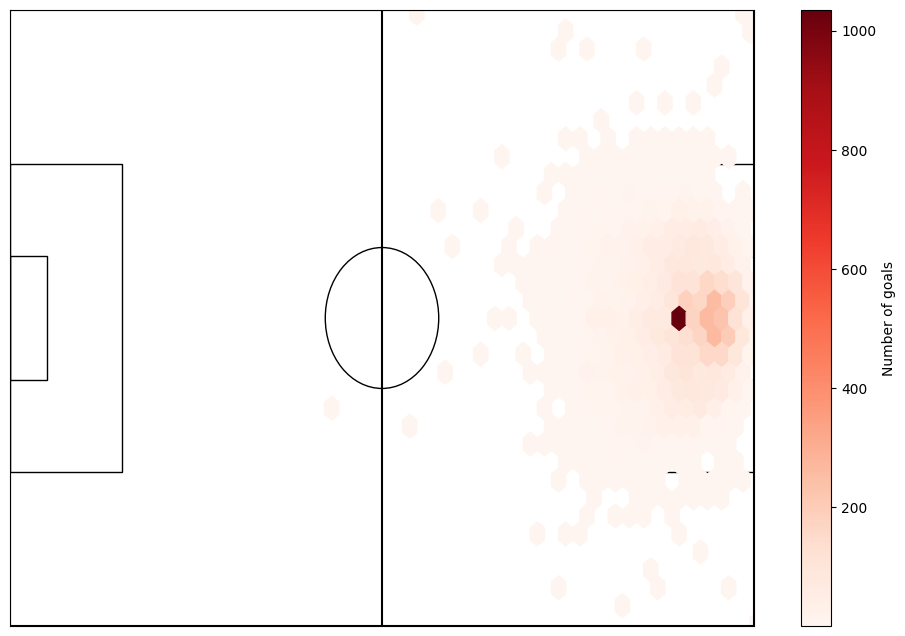

In [36]:
# aplicamos solo la conversión cuando la ubicación es una cadena
goles_df['location'] = goles_df['location'].apply(convert_location, meta=('location', 'object'))

# filtramos por aquellos tiros de los que tengamos su posición
goles_posicion_df = goles_df[goles_df['location'].notnull()]

# extraemos las coordenadas X y Y de la columna 'location'
goles_posicion_df['x'] = goles_posicion_df['location'].apply(lambda loc: loc[0] if isinstance(loc, list) else None, meta=('x', 'f8'))
goles_posicion_df['y'] = goles_posicion_df['location'].apply(lambda loc: loc[1] if isinstance(loc, list) else None, meta=('y', 'f8'))

# crear el gráfico
fig, ax = plt.subplots(figsize=(12, 8))
draw_pitch(ax)

# crear el mapa de calor usando histograma 2D
hb = ax.hexbin(
    goles_posicion_df['x'], goles_posicion_df['y'],
    gridsize=30, cmap='Reds', mincnt=1
)

# añadimos la barra de colores
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Number of goals')

# guardamos la imagen
heatmap_img_path = 'heatmap_goals.png'
plt.savefig(heatmap_img_path, bbox_inches='tight')

# mostramos el gráfico
plt.show()

Vamos a hacerlo ahora utilizando un campo más parecido a un campo de fútbol utilizando la librería mplsoccer cargada al inicio.

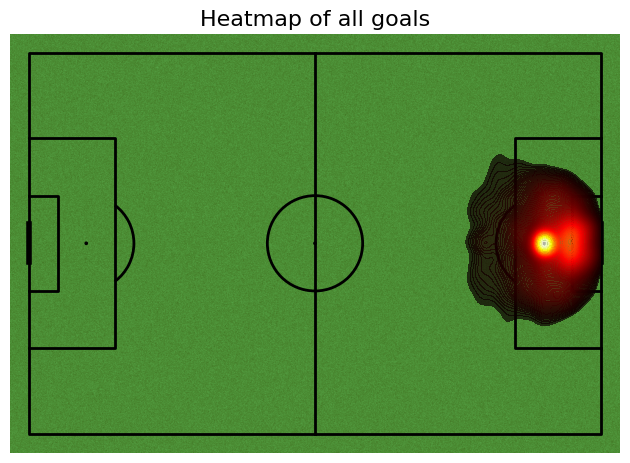

In [37]:
pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='grass')
fig, ax = pitch.draw()

# dibujar el mapa de calor de los goles
pitch.kdeplot(goles_posicion_df['x'], goles_posicion_df['y'], ax=ax, shade=True, levels=100, cmap='hot', alpha=0.7)

plt.title(f"Heatmap of all goals", fontsize=16)
plt.show()

Como podemos ver la mayoría de los goles son aquellos tiros que se han hecho desde una distancia muy cercana a la portería (casi todos dentro del área y muy cerca del punto de penalti), aunque también hay algunos que han sido de una distancia algo más lejana a la portería.

### Tipos de pases por altura y posiciones de jugadores en el terreno de juego que hacen más pases

Vamos a presentar un gráfico en el que podamos ver el porcentaje de cada tipo de pase respecto a todos los pases que tenemos guardados. Los pases los vamos a clasificar según su altura, es decir, pase a ras de suelo, pase alto...

In [22]:
# filtramos por los eventos que sean tiros
pases_df = events_df[events_df['type_name'] == 'Pass']
num_pases = pases_df.shape[0].compute()
print("Number of 'Pass' type events:", num_pases)

Number of 'Pass' type events: 3358652


In [23]:
# convertimos la columna 'pass' de cadena a diccionario, si no es NaN, como hicimos con la columna 'type' anteriormente en el apartado de ver 
# la frecuencia de los goles
pases_df['pass'] = pases_df['pass'].map_partitions(lambda df: df.apply(str_to_dict), meta=('pass', 'object'))

In [24]:
# función para clasificar el pase según el tipo de altura
def clasify_pass_by_height(row):
    if isinstance(row, dict) and 'height' in row:
        height_name = row['height'].get('name', None)
        if height_name:
            return height_name
    return 'Unknown' 

# creamos una nueva columna para indicar el tipo de pase según la altura
pases_df['pass_height'] = pases_df['pass'].map_partitions(lambda df: df.apply(clasify_pass_by_height), meta=('pass_height', 'object'))

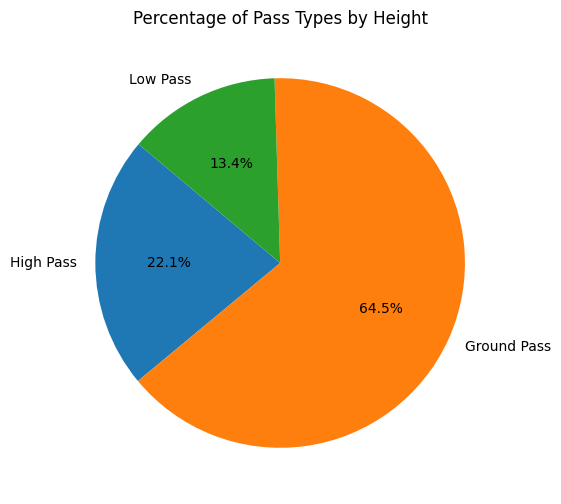

In [25]:
# calculamos la cuenta de pases por tipo de altura
pases_por_altura = pases_df['pass_height'].value_counts().compute()

# calculamos el porcentaje de cada tipo de pase
porcentaje_pases_por_altura = (pases_por_altura / pases_por_altura.sum()) * 100

# creamos el diagrama de sectores
plt.figure(figsize=(6, 6))
plt.pie(
    porcentaje_pases_por_altura,
    labels=porcentaje_pases_por_altura.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Percentage of Pass Types by Height")
plt.show()

Como podemos observar, la mayoría de pases son pases rasos (*Ground Pass*) y esto se debe a que son los pases más fáciles de hacer técnicamente hablando. Luego en un tanto por ciento mayor tenemos los pases altos (*High Pass*) y los pases a media altura (*Low Pass*) y esto se debe a que estos pases son más difíciles de realizar técnicamente hablando y también que es más difícil de realizar un buen control por parte del compañero al que le damos el pase.

Ahora, vamos a representar el porcentaje de pases respecto al total de pases de una posición de un jugador en el terreno de juego.

In [33]:
# convertimos la columna 'pass' de cadena a diccionario, si no es NaN, como hicimos con la columna 'type' anteriormente en el apartado de ver 
# la frecuencia de los goles
pases_df['position'] = pases_df['position'].map_partitions(lambda df: df.apply(str_to_dict), meta=('position', 'object'))

In [34]:
# función para obtener la posición del jugador que ha dado el pase
def clasify_pass_by_player_position(row):
    if isinstance(row, dict) and 'name' in row:
        return row['name']
    return 'Unknown'

# creamos una nueva columna para indicar la posición del jugador que ha dado el pase
pases_df['pass_player_position'] = pases_df.map_partitions(lambda df: df.apply(lambda x: clasify_pass_by_player_position(x['position']), axis=1),
                                                           meta=('pass_player_position', 'object'))

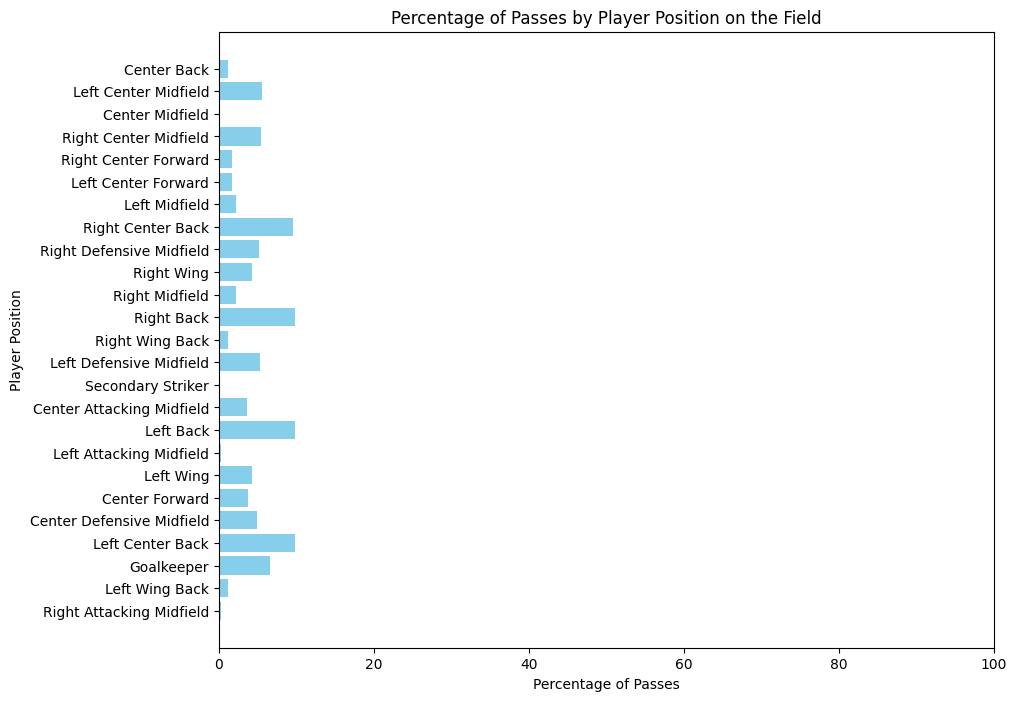

In [35]:
# calculamos la cuenta de pases por posición del jugador que ha dado el pase
pases_por_posicion = pases_df['pass_player_position'].value_counts().compute()

# calculamos el porcentaje de cada tipo de posición
porcentaje_pases_por_posicion = (pases_por_posicion / pases_por_posicion.sum()) * 100

# creamos el gráfico de barras
plt.figure(figsize=(10, 8))
plt.barh(
    porcentaje_pases_por_posicion.index,
    porcentaje_pases_por_posicion,
    color='skyblue'
)
plt.xlabel('Percentage of Passes')
plt.ylabel('Player Position')
plt.title('Percentage of Passes by Player Position on the Field')
plt.xlim(0, 100)
plt.show()

Como podemos observar, el porcentaje de pases según el tipo de posición esta bastante igualado, aunque es cierto que los que más destacan son defensas, esto se debe a que se dan varios pases de seguridad entre los defensas para no perder la posesión del balón.

### Top 10 jugadores con más apariciones por competición y por competición y equipo

Vamos a calcular los 10 jugadores que más apariciones (hayan jugado un partido, ya sea desde el once titular o saliendo desde el banquillo) han tenido en partidos dentro de una competición (a partir de atributo competition_key, creada en el primer apartado para obtener información acerca de las competiciones).

In [66]:
import json


ruta_lineups = ruta_datos + "lineups/"

def load_lineups_by_competition(competition_key, ruta_lineups, matches_df):
    # obtenemos los match_id para la competición deseada
    partidos_competicion = matches_df[matches_df['competition_key'] == competition_key]['match_id'].tolist()
    # filtramos archivos de alineación que coincidan con los match_id
    lineups_data = []
    for match_id in partidos_competicion:
        archivo = os.path.join(ruta_lineups, f"{match_id}.json")
        if os.path.exists(archivo):
            with open(archivo, 'r', encoding='utf-8') as f:
                lineup_json = json.load(f)
                lineups_data.append(lineup_json)
    # convertimos la lista de alineaciones en un DataFrame
    return pd.DataFrame(lineups_data)

In [67]:
def top_10_players_by_appearances(lineups_df):
    apariciones = []
    for _, row in lineups_df.iterrows():
        for team in row:
            for player in team['lineup']:
                if ('positions' in player and isinstance(player['positions'], list) and len(player['positions']) > 0):
                    apariciones.append(player['player_name'])
    # contamos las apariciones de cada jugador
    apariciones_jugadores = pd.Series(apariciones).value_counts().head(10)
    # convertimos a DataFrame para una mejor visualización
    top_jugadores_df = apariciones_jugadores.reset_index()
    top_jugadores_df.columns = ['Player', 'Appearances']
    # reiniciamos el índice para que empiece en 1
    top_jugadores_df.index = top_jugadores_df.index + 1
    return top_jugadores_df

Ejemplo de uso para la Eurocopa masculina de 2024.

In [72]:
competition_key = "UEFA Euro (2024, male)"
lineups_df_euro_24_male = load_lineups_by_competition(competition_key, ruta_lineups, matches_df)

In [73]:
top_jugadores_euro_24_male = top_10_players_by_appearances(lineups_df_euro_24_male)

In [74]:
top_jugadores_euro_24_male.head(10)

,Player,Appearances
1,Mikel Merino Zazón,7
2,Jude Bellingham,7
3,Harry Kane,7
4,Phil Foden,7
5,Bukayo Saka,7
6,Álvaro Borja Morata Martín,7
7,Lamine Yamal Nasraoui Ebana,7
8,John Stones,7
9,Jordan Pickford,7
10,Declan Rice,7


Como podemos ver coincide que son los jugadores ingleses los que aparecen ya que es una de las dos selecciones que disputo la final del europeo, lo que quiere decir que si estos jugadores participaron en todos los partidos que disputo su selección en el torneo esta claro que son los que más jugaron junto a la otra selección que llego a la final (la selección española).

Ahora vamos a mostrar los mismo solo que además de poder filtrar por competición podemos filtrar por un equipo que haya disputado tal competición.

In [84]:
def top_10_players_by_appearances_by_team(lineups_df, team_name):
    apariciones = []
    for _, row in lineups_df.iterrows():
        for team in row:
            if team['team_name'] == team_name:
                for player in team['lineup']:
                    if ('positions' in player and isinstance(player['positions'], list) and len(player['positions']) > 0):
                        apariciones.append(player['player_name'])
    # contamos las apariciones de cada jugador
    apariciones_jugadores = pd.Series(apariciones).value_counts().head(10)
    # convertimos a DataFrame para una mejor visualización
    top_jugadores_df = apariciones_jugadores.reset_index()
    top_jugadores_df.columns = ['Player', 'Appearances']
    # reiniciamos el índice para que empiece en 1
    top_jugadores_df.index = top_jugadores_df.index + 1
    return top_jugadores_df

Ejemplo de uso para la Eurocopa masculina de 2024, para la selección de España.

In [87]:
top_jugadores_euro_24_male_spain = top_10_players_by_appearances_by_team(lineups_df_euro_24_male, "Spain")

In [88]:
top_jugadores_euro_24_male_spain.head(10)

,Player,Appearances
1,Mikel Merino Zazón,7
2,Álvaro Borja Morata Martín,7
3,Mikel Oyarzabal Ugarte,7
4,Lamine Yamal Nasraoui Ebana,7
5,Fabián Ruiz Peña,6
6,Rodrigo Hernández Cascante,6
7,Unai Simón Mendibil,6
8,Daniel Olmo Carvajal,6
9,Aymeric Laporte,6
10,Nicholas Williams Arthuer,6


Ejemplo de uso para la La Liga, temporada 2015/2016, masculina, para la liga en general y para el equipo Sevilla FC.

In [90]:
competition_key = "La Liga (2015/2016, male)"
lineups_df_laliga_1516_male = load_lineups_by_competition(competition_key, ruta_lineups, matches_df)

In [91]:
top_jugadores_laliga_1516_male = top_10_players_by_appearances(lineups_df_laliga_1516_male)

In [94]:
top_jugadores_laliga_1516_male.head(10)

,Player,Appearances
1,Sergio Enrich Ametller,38
2,Vicente Guaita Panadero,38
3,Rubén Castro Martín,38
4,Fayçal Fajr,38
5,Jan Oblak,38
6,Antoine Griezmann,38
7,Andrés Eduardo Fernández Moreno,37
8,Gorka Iraizoz Moreno,37
9,Pedro Mosquera Parada,37
10,Ivan Rakitić,36


In [97]:
top_jugadores_laliga_1516_male_sevilla = top_10_players_by_appearances_by_team(lineups_df_laliga_1516_male, "Sevilla")

In [98]:
top_jugadores_laliga_1516_male_sevilla.head(10)

,Player,Appearances
1,Sergio Rico González,34
2,Yevhen Konoplyanka,32
3,Kevin Gameiro,31
4,Timothée Kolodziejczak,29
5,Vicente Iborra De La Fuente,29
6,Víctor Machín Pérez,28
7,Adil Rami,28
8,Steven N''Kemboanza Mike Christopher Nzonzi,28
9,Michael Krohn-Dehli,27
10,Grzegorz Krychowiak,26
